### Building a text classifier for classifying news articles

In this notebook, I will
1. Scrape data from a website called Inshorts
2. Scrape data for 3 news categories : sports, world, technology
3. Scrape news headline and news article
3. Build a text classifier to classify the news articles

Disclosure : web scraping code is referred from https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [1]:
#Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

1. requests to get the access to HTML content from the landing page
2. BeautifulSoup to parse the data and extract headline and articls for all the 3 categories (sports, technology and world affairs)

In [2]:
#urls to the news articles
seed_urls = ['https://www.inshorts.com/en/read/sports',
            'https://www.inshorts.com/en/read/technology',
            'https://www.inshorts.com/en/read/world']

In [3]:
#Function for scraping the data from given urls
def build_datasets(seed_urls):
    
    news_data = []
    
    for url in seed_urls:
        news_category = url.split('/')[-1]
        
        data = requests.get(url)
        soup = BeautifulSoup(data.content,'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
  
    return df

In [4]:
news_df_new = build_datasets(seed_urls)

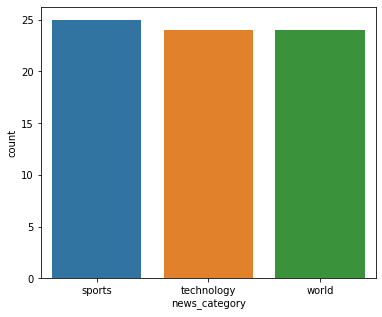

In [5]:
#Distribution of news articles over 3 categories
fig = plt.figure(figsize=(6,5))
sns.countplot(news_df_new.news_category)

In [6]:
news_df_new.head()

,news_headline,news_article,news_category
0,Kumble should be chief selector but BCCI needs...,Ex-India batsman Virender Sehwag has said that...,sports
1,"We are here to win, not see how many helmets w...",After Steve Smith was hit by a Jofra Archer bo...,sports
2,Pak cricketer Hassan Ali marries Haryana girl ...,Pakistan fast bowler Hassan Ali tied the knot ...,sports
3,Paytm gets BCCI's title sponsorship rights for...,The BCCI today announced that Paytm has acquir...,sports
4,"NZ Women's same-sex couple Satterthwaite, Tahu...",New Zealand Women captain Amy Satterthwaite an...,sports


In [7]:
news_df_new.shape

(73, 3)

In [8]:
#As the data is small, I will use the data that I scraped earlier (one day ago)
news_df_old = pd.read_csv('Inshorts_news_day1.csv',usecols = ['news_headline','news_article','news_category'])
news_df_old.head()

,news_headline,news_article,news_category
0,Sreesanth's life ban reduced to 7 years by BCC...,Pacer S Sreesanth's life ban for his involveme...,sports
1,"NZ Women's same-sex couple Satterthwaite, Tahu...",New Zealand Women captain Amy Satterthwaite an...,sports
2,What is the yellow symbol Aussie players have ...,The yellow symbol on the shirt collars of Aust...,sports
3,21-yr-old Duckhee becomes 1st deaf player to w...,South Korea's 21-year-old Duckhee Lee has beco...,sports
4,Hassan pulls off 'bomb explosion' celebration ...,A video of Pakistani fast bowler Hassan Ali pu...,sports


In [9]:
#concatenating news_df and news_df_old
news_df = news_df_new.append(news_df_old)
news_df.head()

,news_headline,news_article,news_category
0,Kumble should be chief selector but BCCI needs...,Ex-India batsman Virender Sehwag has said that...,sports
1,"We are here to win, not see how many helmets w...",After Steve Smith was hit by a Jofra Archer bo...,sports
2,Pak cricketer Hassan Ali marries Haryana girl ...,Pakistan fast bowler Hassan Ali tied the knot ...,sports
3,Paytm gets BCCI's title sponsorship rights for...,The BCCI today announced that Paytm has acquir...,sports
4,"NZ Women's same-sex couple Satterthwaite, Tahu...",New Zealand Women captain Amy Satterthwaite an...,sports


In [10]:
news_df.shape

(146, 3)

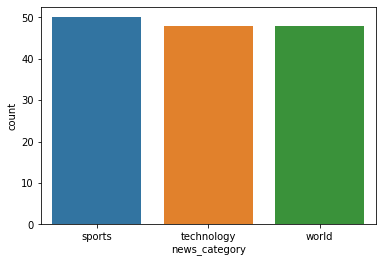

In [11]:
sns.countplot(news_df.news_category)

In [12]:
#Combining news article and news headline into a new column 'news'
news_df['news'] = news_df['news_headline']+news_df['news_article']

### I will build 3 classifiers to compare the performance for 3 cases :
1. Only news headline as feature
2. Only news article as feature
3. news article and news headline both as features

In [13]:
#splitting train and test data into 75% and 25% respectively
from sklearn.model_selection import train_test_split
X_news = news_df[['news']]
X_news_article = news_df[['news_article']]
X_news_headline = news_df[['news_headline']]
y = news_df['news_category']

#Case 1
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(X_news,y,stratify = y, test_size =0.25, random_state=42)

#Case 2
X_train_news_article, X_test_news_article, y_train_news_article, y_test_news_article = train_test_split(X_news_article,y,stratify = y, test_size =0.25, random_state=42)

#Case 3
X_train_news_headline, X_test_news_headline, y_train_news_headline, y_test_news_headline = train_test_split(X_news_headline,y,stratify = y, test_size =0.25, random_state=42)


In [14]:
#each category has equal number of samples. 
y_train_news.value_counts()

sports        37
technology    36
world         36
Name: news_category, dtype: int64

### Building pipeline to first process the text data using TFIDF and then classifying using RidgeClassifier
#### 1. max_df and min_df parameters are tuned for TFIDF.
#### 2. alpha is tuned for ridge classifier.
#### 3. StratifiedKFold is used for preserving the percentage of samples for each class.
#### 4. ngram_range for TFIDF is set to (1,2), using unigrams and bigrams.

In [15]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

cv = StratifiedKFold(n_splits=5)

pipeline = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),
                     ('clf',RidgeClassifier())])

param_grid = ({'tfidf__max_df':[.6,.7,.8,.9],
              'tfidf__min_df':[0,.1,.2],
              'clf__alpha': [.001,.01,.1,1,10,100,1000]})

grid_search = GridSearchCV(estimator=pipeline, cv=5, param_grid=param_grid)

### Case 1: Using only news_headline

In [16]:
grid_search.fit(X_train_news_headline.news_headline, y_train_news_headline)
y_pred_news_headline = grid_search.predict(X_test_news_headline.news_headline)

news_headline_report = classification_report(y_pred=y_pred_news_headline, y_true = y_test_news_headline)
print(news_headline_report)

              precision    recall  f1-score   support

      sports       0.87      1.00      0.93        13
  technology       0.92      1.00      0.96        12
       world       1.00      0.75      0.86        12

   micro avg       0.92      0.92      0.92        37
   macro avg       0.93      0.92      0.92        37
weighted avg       0.93      0.92      0.92        37



/Users/ramya.gowda/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Case 2: Using only news article

In [17]:
grid_search.fit(X_train_news_article.news_article, y_train_news_article)
y_pred_news_article = grid_search.predict(X_test_news_article.news_article)

news_article_report = classification_report(y_pred=y_pred_news_article, y_true = y_test_news_article)
print(news_article_report)

              precision    recall  f1-score   support

      sports       1.00      1.00      1.00        13
  technology       0.92      1.00      0.96        12
       world       1.00      0.92      0.96        12

   micro avg       0.97      0.97      0.97        37
   macro avg       0.97      0.97      0.97        37
weighted avg       0.98      0.97      0.97        37



/Users/ramya.gowda/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Case 3: Using both news headline and article

In [18]:
grid_search.fit(X_train_news.news, y_train_news)
y_pred_news = grid_search.predict(X_test_news.news)

news_report = classification_report(y_pred=y_pred_news, y_true = y_test_news)
print(news_report)

              precision    recall  f1-score   support

      sports       1.00      1.00      1.00        13
  technology       0.92      1.00      0.96        12
       world       1.00      0.92      0.96        12

   micro avg       0.97      0.97      0.97        37
   macro avg       0.97      0.97      0.97        37
weighted avg       0.98      0.97      0.97        37



/Users/ramya.gowda/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In conclusion, performance improved for all the three categories from using only news headline to using news article. 
But the performance doesn't change when both news article and news headline are conctenated showing that news headline does not contribute in performance improvement.